In [1]:
import os
os.environ['IPIE_USE_GPU'] = "1"

from ipie.config import config

config.update_option("use_gpu", True)

import numpy as np
from src.utils_ipie import get_molecular_hamiltonian
from src.vqe_cudaq_qnp import VQE
from ipie.qmc.afqmc import AFQMC
from ipie.analysis.extraction import extract_observable
from src.utils_ipie import get_afqmc_data
import matplotlib.pyplot as plt

In [2]:
# fresh cudaq container 
# pip install -r requirements.txt 
# !echo cuda-quantum | sudo -S apt-get install -y cuda-toolkit-11.8 && python -m pip install cupy

# took 16 minutes

In [3]:
num_active_orbitals = 5
num_active_electrons = 8
spin = 0
geometry = "systems/geo_o3.xyz"
basis = "sto-3g"
num_vqe_layers = 1
random_seed = 1

n_qubits = 2 * num_active_orbitals

data_hamiltonian = get_molecular_hamiltonian(geometry=geometry,
                                             basis=basis,
                                             num_active_electrons=num_active_electrons,
                                             num_active_orbitals=num_active_orbitals,
                                             create_cudaq_ham=True,
                                             )

hamiltonian = data_hamiltonian["hamiltonian"]
pyscf_data = data_hamiltonian["scf_data"]

MINIMIZE_METHODS = ['Nelder-Mead', 'Powell', 'CG', 'BFGS', 'L-BFGS-B', 'TNC', 'COBYLA', 'SLSQP']

optimizer_type = 'Nelder-Mead'
np.random.seed(random_seed)
print(f"# {optimizer_type}, {num_vqe_layers}")

options = {'n_vqe_layers': num_vqe_layers,
           'maxiter': 100,
           'energy_core': pyscf_data["energy_core_cudaq_ham"],
           'return_final_state_vec': True,
           'optimizer': optimizer_type,
           'target': 'nvidia',
           'target_option': 'mqpu'}

vqe = VQE(n_qubits=n_qubits,
          num_active_electrons=num_active_electrons,
          spin=spin,
          options=options)

vqe.options['initial_parameters'] = np.random.rand(vqe.num_params)

result = vqe.execute(hamiltonian)

# Best energy from VQE
optimized_energy = result['energy_optimized']
vqe_energies = result["callback_energies"]
# Final state vector from VQE
final_state_vector = result["state_vec"]

# Start Hartree-Fock computation
# Start CAS computation
# Nelder-Mead, 1
# Set target nvidia with options mqpu
# num gpus= 5
# Initial energy:  -221.21692381614577
# Start VQE minimization
# Num params: 8
# Qubits: 10
# N_layers: 1
# Energy after the VQE: -221.38786344621627
# Time for VQE [min]: 0.01811744769414266


In [4]:
afqmc_hamiltonian, trial_wavefunction = get_afqmc_data(pyscf_data, final_state_vector)

# Setup the AFQMC parameters
afqmc_msd = AFQMC.build(
    pyscf_data["mol"].nelec,
    afqmc_hamiltonian,
    trial_wavefunction,
    num_walkers=100,
    num_steps_per_block=25,
    num_blocks=10,
    timestep=0.005,
    stabilize_freq=5,
    seed=random_seed,
    pop_control_freq=5,
    verbose=False)

# Run the AFQMC


# random seed is 1
# There are unused GPUs (1 MPI tasks but 5 GPUs).  Check if this is really what you wanted.
            Block                   Weight            WeightFactor            HybridEnergy                  ENumer                  EDenom                  ETotal                  E1Body                  E2Body
                0   1.0000000000000000e+02  1.0000000000000000e+02  0.0000000000000000e+00 -2.2138950911170457e+04  1.0000000000000000e+02 -2.2138950911170457e+02 -3.7463719370401685e+02  1.5324768459231223e+02


/usr/local/lib/python3.10/dist-packages/numba/cuda/dispatcher.py:536: NumbaPerformanceWarning: Grid size 24 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


                1   3.9322174839315630e+02  1.2722348488017276e+03 -1.1214735834315120e+02 -2.2142640285335594e+04  1.0000000000000000e+02 -2.2142640285335594e+02 -3.7465643015954697e+02  1.5323002730619092e+02
                2   1.0002567027357382e+02  3.4820782093050485e+02 -1.1217713856940627e+02 -2.2145349779530363e+04  1.0000000000000000e+02 -2.2145349779530363e+02 -3.7466163631057128e+02  1.5320813851526759e+02
                3   1.0002756525443061e+02  1.0002783808101620e+02 -1.1220069764120407e+02 -2.2146775630703924e+04  1.0000000000000001e+02 -2.2146775630703920e+02 -3.7466402057932515e+02  1.5319626427228596e+02
                4   1.0001006426812228e+02  1.0004388030937957e+02 -1.1222885903298786e+02 -2.2147836619182584e+04  9.9999999999999986e+01 -2.2147836619182590e+02 -3.7466427185507297e+02  1.5318590566324707e+02
                5   1.0004401548252103e+02  1.0009963071542225e+02 -1.1226705438687355e+02 -2.2150757542732896e+04  1.0000000000000003e+02 -2.21507575427328

In [6]:
afqmc_msd.run()


# There are unused GPUs (1 MPI tasks but 5 GPUs).  Check if this is really what you wanted.
            Block                   Weight            WeightFactor            HybridEnergy                  ENumer                  EDenom                  ETotal                  E1Body                  E2Body
                0   9.9999999999999986e+01  9.9875378995424953e+01 -1.1219688553652188e+02 -2.2151033158770464e+04  9.9999999999999986e+01 -2.2151033158770468e+02 -3.7473950290864411e+02  1.5322917132093943e+02
                1   1.1214061113762337e+02  1.1525676518968619e+02 -1.1229621250614093e+02 -2.2152117479491357e+04  1.0000000000000001e+02 -2.2152117479491352e+02 -3.7470329421024940e+02  1.5318211941533582e+02
                2   9.9962460348538031e+01  9.9926889099652797e+01 -1.1228443704102047e+02 -2.2151855210782884e+04  1.0000000000000001e+02 -2.2151855210782881e+02 -3.7471992946415179e+02  1.5320137735632304e+02
                3   9.9975191341756954e+01  9.9943535011218827e+

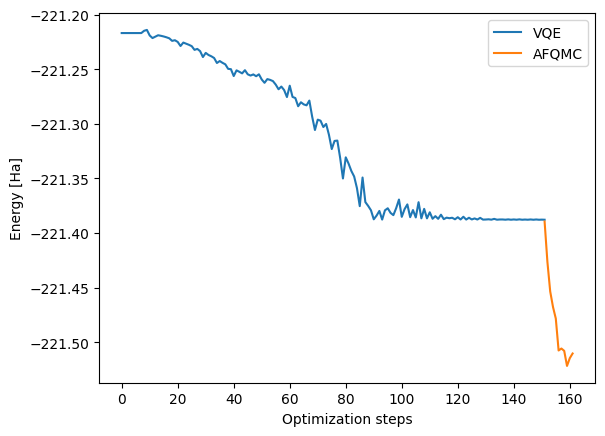

In [5]:
afqmc_msd.finalise(verbose=False)

# Extract the energies
qmc_data = extract_observable(afqmc_msd.estimators.filename, "energy")


vqe_y = vqe_energies
vqe_x = list(range(len(vqe_y)))
plt.plot(vqe_x, vqe_y, label="VQE")

afqmc_y = list(qmc_data["ETotal"])
afqmc_x = [i + vqe_x[-1] for i in list(range(len(afqmc_y)))]
plt.plot(afqmc_x, afqmc_y, label="AFQMC")

plt.xlabel("Optimization steps")
plt.ylabel("Energy [Ha]")
plt.legend()

plt.savefig('vqe_afqmc_plot.png')